In [2]:
# Update pip and install dependencies
!pip install --upgrade pip
!pip install PyWavelets antropy ace_tools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [antropy]


In [ ]:
!pip install ace_tools

In [1]:
# Cell 2: Imports & Drive Mount
from google.colab import drive
drive.mount('/content/drive')

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats
from scipy.integrate import trapezoid
import pywt
import antropy as ant
from tqdm.auto import tqdm
from IPython.display import clear_output


# === Adjust this to the SHL data root ===
DATA_ROOT = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/train_4_locations'  # or 'test', 'validation'

# Define sensor locations and modalities
LOCATIONS = ['Bag', 'Hips', 'Torso', 'Hand']
MODALITIES = {
    'Acc': ['x','y','z'],
    'Gyr': ['x','y','z'],
    'Mag': ['x','y','z'],
    'Label': [''],
}

# Utility to find all .txt files
def gather_files(root):
    files = []
    for loc in LOCATIONS:
        loc_path = os.path.join(root, loc)
        for mod, axes in MODALITIES.items():
            for axis in axes:
                if mod == 'Label':
                    pattern = f"{mod}" + ".txt"
                else:
                    pattern = f"{mod}" + (f"_{axis}" if axis else "") + ".txt"
                files.extend(glob.glob(os.path.join(loc_path, pattern)))
    return files

all_txt_files = gather_files(DATA_ROOT)
print(f"Found {len(all_txt_files)} files across {LOCATIONS}")


Mounted at /content/drive


ModuleNotFoundError: No module named 'pywt'

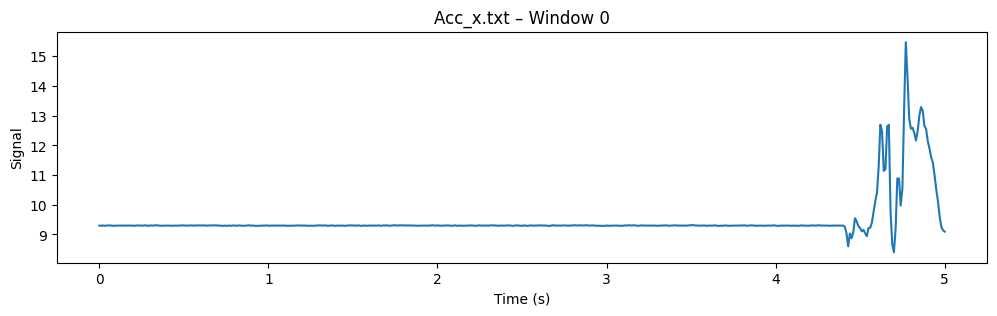

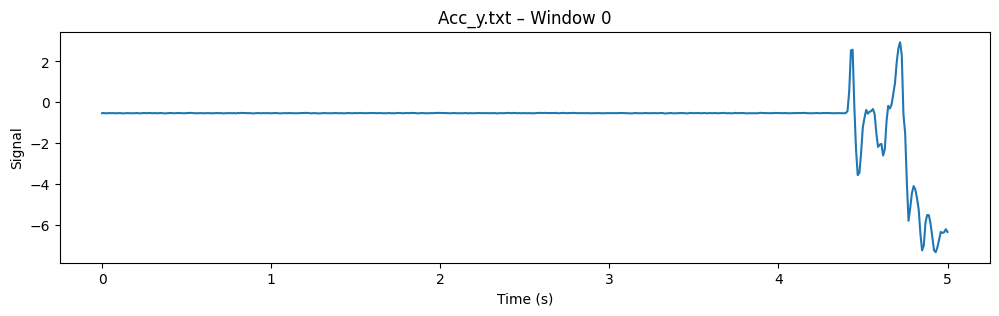

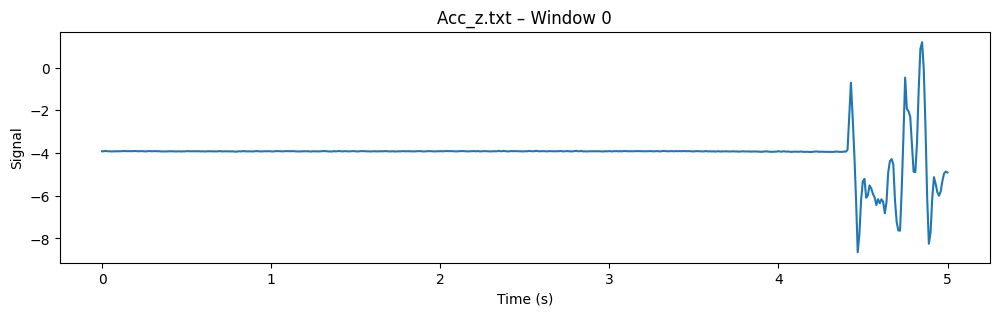

In [ ]:
def preview_window(file_path, window_idx=0):
    """Plot a single 5s window from a .txt file."""
    data = np.loadtxt(file_path)
    window = data[window_idx]    # shape (500,)
    plt.figure(figsize=(12,3))
    plt.plot(np.linspace(0,5,500), window)
    plt.title(os.path.basename(file_path) + f" – Window {window_idx}")
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.show()

# Preview first window of a few files
for f in all_txt_files[:3]:
    preview_window(f)


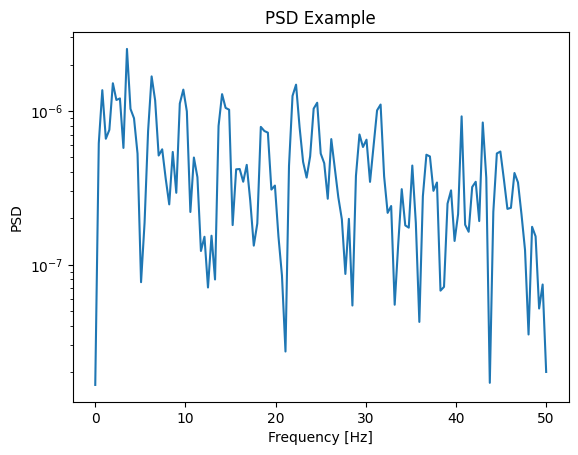

In [ ]:
# PSD of a single window
fs = 100  # from dataset spec
sig = np.loadtxt(all_txt_files[0])[0]
f, Pxx = signal.welch(sig, fs=fs, nperseg=256)
plt.semilogy(f, Pxx)
plt.title('PSD Example')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.show()


In [ ]:
# ── Cell 3: Helpers for entropy & band energy ─────────────────────────────────

def differential_entropy(x):
    """
    Gaussian differential entropy of a 1D array x (in nats):
        h = 0.5 * ln(2πe·σ²)
    """
    var = np.var(x)
    return 0.5 * np.log(2 * np.pi * np.e * var)


def band_energy(psd, freqs, band):
    """
    Integrate PSD (or any power spectrum) over a given [low, high) Hz band
    using trapezoidal rule.
    """
    mask = (freqs >= band[0]) & (freqs < band[1])
    return trapezoid(psd[mask], freqs[mask])


In [ ]:
# Cell 4: Funkcje ekstrakcji cech (70+ na okno)

def znormalize(x):
    return (x - x.mean()) / x.std()  # normalizacja do średniej 0 i odchylenia 1

def spectral_features(x, fs=100):
    xz = znormalize(x)
    freqs, Pxx = signal.welch(xz, fs=fs, nperseg=fs*2)  # PSD: gęstość widmowa mocy
    Xd = np.abs(np.fft.rfft(xz))                       # magnituda DCT (FFT)
    fd = np.fft.rfftfreq(len(xz), 1/fs)                 # odpowiadające częstotliwości

    bands = [(0.1,0.5),(0.5,1),(1,1.5),(1.5,2),(2,2.5),(2.5,3),
             (3,4),(4,5),(5,6),(6,8),(8,12),(12,18),
             (18,24),(24,28),(28,32),(32,40),(40,50)]
    feats = {}
    for prefix, f_arr, p_arr in [('psd', freqs, Pxx), ('dct', fd, Xd)]:
        for b in bands:
            feats[f'{prefix}_band_{b[0]}_{b[1]}'] = band_energy(p_arr, f_arr, b)
            # energia w paśmie b[0]-b[1] Hz

        cen = (f_arr * p_arr).sum() / p_arr.sum()
        feats[f'{prefix}_centroid']  = cen                                      # centroid widma: środek ciężkości energii częstotliwościowej

        bw = np.sqrt(((f_arr-cen)**2 * p_arr).sum() / p_arr.sum())
        feats[f'{prefix}_bandwidth'] = bw                                       # szerokość pasma: rozproszenie mocy wokół centroidu

        top2 = np.sort(p_arr)[-2:]
        feats[f'{prefix}_top2_ratio'] = top2[-1] / (top2[-2] + 1e-12)           # stosunek dwóch największych amplitud

        feats[f'{prefix}_amp_max']  = p_arr.max()                               # maksymalna amplituda widma

        feats[f'{prefix}_amp_std']  = p_arr.std()                               # odchylenie standardowe amplitud

        feats[f'{prefix}_amp_skew'] = stats.skew(p_arr)                         # skośność rozkładu amplitud

        pk = f_arr[np.argmax(p_arr)]
        feats[f'{prefix}_peak_freq'] = pk                                       # częstotliwość szczytowa

        top5_idx = np.argsort(p_arr)[-5:]
        top5 = f_arr[top5_idx]
        feats[f'{prefix}_top5_mean'] = top5.mean()                              # średnia 5 dominujących częstotliwości

        feats[f'{prefix}_top5_std']  = top5.std()                               # odchylenie standardowe 5 dominujących częstotliwości

        feats[f'{prefix}_top5_skew'] = stats.skew(top5)                         # skośność 5 dominujących częstotliwości

    p_norm = Pxx / Pxx.sum()
    feats['spectral_entropy'] = -(p_norm * np.log2(p_norm+1e-12)).sum()         # entropia widmowa: miara nieuporządkowania rozkładu mocy

    return feats

def time_acf_features(x):
    x0 = x - x.mean()
    acf = np.correlate(x0, x0, mode='full')[len(x0)-1:]
    feats = {
        'acf_mean_abs':       np.abs(acf).mean(),                     # średnia wartość bezwzględna ACF

        'acf_std':            acf.std(),                              # odchylenie standardowe ACF

        'acf_skew':           stats.skew(acf),                        # skośność ACF

        'acf_zero_crossings': ((acf[:-1]*acf[1:])<0).sum(),           # liczba zmian znaku w ACF
    }
    f_acf, P_acf = signal.welch(acf, fs=1)
    feats['acf_prom_freq'] = f_acf[P_acf.argmax()]
    # dominująca częstotliwość ACF

    p_acf = P_acf / P_acf.sum()
    feats['acf_spectral_entropy'] = -(p_acf * np.log2(p_acf+1e-12)).sum()
    # entropia widmowa ACF

    return feats

def time_signal_features(x):
    return {
        'mean_crossing_rate': ((x[:-1]*x[1:])<0).sum()/len(x),        # częstość przekroczeń średniej wartości (sign changes)

        'diff_entropy':       differential_entropy(x),                # entropia różnicowa Gaussa h=0.5·ln(2πeσ²)

        'skew':               stats.skew(x),                          # skośność rozkładu wartości

        'kurtosis':           stats.kurtosis(x),                      # kurtoza – miara smukłości rozkładu

        'hjorth_mobility':    ant.hjorth_params(x)[0],                # mobilność Hjortha – średnia częstotliwość

        'hjorth_complexity':  ant.hjorth_params(x)[1],                # złożoność Hjortha – zmiana mobilności

        'katz_fd':            ant.katz_fd(x),                         # wymiar fraktalny Katz’a – złożoność czasowa
    }

def extra_features(x, fs=100):
    feats = {'ptp_amp': np.ptp(x)}                                  # peak-to-peak: max–min amplitudy
    coeffs = pywt.wavedec(x, 'db4', level=3)
    for i, c in enumerate(coeffs):
        feats[f'wavelet_energy_L{i}'] = np.sum(c**2)                # energia na poziomie falki

    feats['sample_entropy'] = ant.sample_entropy(x)                 # sample entropy: miara nieregularności sygnału

    return feats


# Wyjaśnienia terminów

**Autokorelacja (ACF):** miara podobieństwa sygnału do swojej opóźnionej kopii, pomaga wykryć powtarzalność i okresowość w danych czasowych

**Centroid widma:** „środek ciężkości” rozkładu mocy widmowej, wskazuje, gdzie koncentruje się energia częstotliwościowa sygnału.

**Szerokość pasma:** odchylenie standardowe energii widma wokół centroidu, obrazujące rozproszenie częstotliwości.

**Entropia widmowa:** mierzy „nieuporządkowanie” lub równomierność rozkładu mocy widmowej; wyższa wartość = bardziej płaski, „niepikowy” wykres.

**Wskaźnik przekroczeń zerowych (ZCR):** liczba zmian znaku sygnału (pozytyw–negatyw) na sekundę, używana np. w detekcji perkusyjnych dźwięków.

**Entropia różnicowa:** ciągły odpowiednik entropii, dla rozkładu Gaussa.

**Mobilność i złożoność Hjortha:** parametry czasowe mierzące wariancję sygnału i jego pochodnych – mobilność ≈ średnia częstotliwość, złożoność ≈ zmiana tej częstotliwości.

**Wymiar fraktalny Katz’a:** miara złożoności sygnału obliczana z odległości między kolejnymi punktami próbek; im wyższy, tym większa „chropowatość”.

**Entropia próbki (sample entropy):** miara złożoności i nieregularności sygnału na podstawie prawdopodobieństwa powtórzeń wzorców.

In [ ]:
# Cell 5: Gather signal files & load labels with tqdm

DATA_ROOT = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/train_4_locations'
LOCATIONS       = ['Bag','Hips','Torso','Hand']
SENSORS         = ['Acc','Gyr','Mag']
AXES            = ['x','y','z']
SAMPLES_PER_FILE = 1000    # ← number of windows to sample from each file

# 1) Gather all signal file paths
signal_files = []
for loc in LOCATIONS:
    for s in SENSORS:
        for ax in AXES:
            pattern = os.path.join(DATA_ROOT, loc, f"{s}_{ax}.txt")
            signal_files += glob.glob(pattern)
if not signal_files:
    raise FileNotFoundError(f"No .txt files under {DATA_ROOT}")

# 2) Extract fixed M samples per file
records = []
for fp in tqdm(signal_files, desc='Files', position=0, leave=False):
    data = np.loadtxt(fp)                # shape: (n_windows, 500)
    n_win = data.shape[0]
    # choose up to SAMPLES_PER_FILE unique indices
    picks = np.random.choice(n_win, size=min(SAMPLES_PER_FILE, n_win),
                             replace=False)
    loc    = os.path.basename(os.path.dirname(fp))
    sensor = os.path.splitext(os.path.basename(fp))[0]

    for i in tqdm(picks, desc=f'{sensor} windows',
                  position=1, leave=False):
        win = data[i]
        feats = {}
        feats.update(spectral_features(win))
        feats.update(time_acf_features(win))
        feats.update(time_signal_features(win))
        feats.update(extra_features(win))
        feats['location']    = loc
        feats['sensor_axis'] = sensor
        feats['window_id']   = i
        records.append(feats)

# 3) Build DataFrame
sample_df = pd.DataFrame(records)
print("Sampled feature set shape:", sample_df.shape)
sample_df.head()


Files:   0%|          | 0/36 [00:00<?, ?it/s]

Acc_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Acc_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Gyr_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_x windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_y windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Mag_z windows:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampled feature set shape: (36000, 77)


,psd_band_0.1_0.5,psd_band_0.5_1,psd_band_1_1.5,psd_band_1.5_2,psd_band_2_2.5,psd_band_2.5_3,psd_band_3_4,psd_band_4_5,psd_band_5_6,psd_band_6_8,...,katz_fd,ptp_amp,wavelet_energy_L0,wavelet_energy_L1,wavelet_energy_L2,wavelet_energy_L3,sample_entropy,location,sensor_axis,window_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.001710,0.002630,0.005986,0.002859,...,3.979947,0.242166,2416.238630,0.020356,0.284872,0.211413,1.411098,Bag,Acc_x,4904
1,0.0,0.0,0.0,0.0,0.0,0.0,0.062259,0.004263,0.001302,0.003249,...,1.744960,20.578026,57041.464733,109.282208,14.295576,2.251187,0.293064,Bag,Acc_x,75167
2,0.0,0.0,0.0,0.0,0.0,0.0,0.006298,0.011313,0.007502,0.011027,...,4.056706,3.931250,46200.044051,18.125772,74.225675,35.562182,1.793301,Bag,Acc_x,130033
3,0.0,0.0,0.0,0.0,0.0,0.0,0.014906,0.006366,0.004420,0.027510,...,5.219011,0.057221,518.308206,0.008353,0.014965,0.028381,1.441748,Bag,Acc_x,92078
4,0.0,0.0,0.0,0.0,0.0,0.0,0.006495,0.017153,0.029920,0.031318,...,4.672659,0.042240,25416.319115,0.002686,0.009707,0.011010,1.577912,Bag,Acc_x,50775


Sampled feature set (first 20 rows):


,psd_band_0.1_0.5,psd_band_0.5_1,psd_band_1_1.5,psd_band_1.5_2,psd_band_2_2.5,psd_band_2.5_3,psd_band_3_4,psd_band_4_5,psd_band_5_6,psd_band_6_8,...,katz_fd,ptp_amp,wavelet_energy_L0,wavelet_energy_L1,wavelet_energy_L2,wavelet_energy_L3,sample_entropy,location,sensor_axis,window_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.001710,0.002630,0.005986,0.002859,...,3.979947,0.242166,2416.238630,0.020356,0.284872,0.211413,1.411098,Bag,Acc_x,4904
1,0.0,0.0,0.0,0.0,0.0,0.0,0.062259,0.004263,0.001302,0.003249,...,1.744960,20.578026,57041.464733,109.282208,14.295576,2.251187,0.293064,Bag,Acc_x,75167
2,0.0,0.0,0.0,0.0,0.0,0.0,0.006298,0.011313,0.007502,0.011027,...,4.056706,3.931250,46200.044051,18.125772,74.225675,35.562182,1.793301,Bag,Acc_x,130033
3,0.0,0.0,0.0,0.0,0.0,0.0,0.014906,0.006366,0.004420,0.027510,...,5.219011,0.057221,518.308206,0.008353,0.014965,0.028381,1.441748,Bag,Acc_x,92078
4,0.0,0.0,0.0,0.0,0.0,0.0,0.006495,0.017153,0.029920,0.031318,...,4.672659,0.042240,25416.319115,0.002686,0.009707,0.011010,1.577912,Bag,Acc_x,50775
5,0.0,0.0,0.0,0.0,0.0,0.0,0.013074,0.009886,0.012876,0.041326,...,4.233336,0.042869,1409.604465,0.003422,0.003342,0.008361,0.887656,Bag,Acc_x,44362
6,0.0,0.0,0.0,0.0,0.0,0.0,0.004360,0.007405,0.004586,0.012777,...,2.618560,0.156967,1430.974708,0.002580,0.005981,0.042268,0.896538,Bag,Acc_x,43998
7,0.0,0.0,0.0,0.0,0.0,0.0,0.005023,0.000896,0.000180,0.002445,...,4.109686,1.459200,36618.133605,2.746762,9.691261,5.561262,2.034194,Bag,Acc_x,152185
8,0.0,0.0,0.0,0.0,0.0,0.0,0.011206,0.003128,0.001131,0.007963,...,2.852017,0.995119,37606.947270,0.747393,2.473137,0.762735,1.594417,Bag,Acc_x,60225
9,0.0,0.0,0.0,0.0,0.0,0.0,0.013891,0.011006,0.022056,0.021853,...,1.816348,13.366571,46643.099130,255.094354,33.205950,2.199335,0.488335,Bag,Acc_x,72553



Summary statistics:


,psd_band_0.1_0.5,psd_band_0.5_1,psd_band_1_1.5,psd_band_1.5_2,psd_band_2_2.5,psd_band_2.5_3,psd_band_3_4,psd_band_4_5,psd_band_5_6,psd_band_6_8,...,hjorth_mobility,hjorth_complexity,katz_fd,ptp_amp,wavelet_energy_L0,wavelet_energy_L1,wavelet_energy_L2,wavelet_energy_L3,sample_entropy,window_id
count,36000.0,36000.0,36000.0,36000.0,36000.0,36000.0,36000.000000,36000.000000,36000.000000,3.600000e+04,...,36000.000000,36000.000000,36000.000000,36000.000000,3.600000e+04,3.600000e+04,3.600000e+04,36000.000000,36000.000000,36000.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.029120,0.021924,0.017426,3.686586e-02,...,0.375217,5.051167,2.321864,9.842418,2.140526e+06,8.794035e+02,2.178788e+02,44.775220,0.770146,98247.747556
std,0.0,0.0,0.0,0.0,0.0,0.0,0.035703,0.028818,0.023950,4.798151e-02,...,0.310193,6.678017,0.917845,27.497475,1.170933e+08,7.352397e+04,7.807516e+03,1092.208316,0.512929,56539.685270
min,0.0,0.0,0.0,0.0,0.0,0.0,0.000006,0.000002,0.000001,9.207850e-07,...,0.006021,1.004403,1.012230,0.001222,1.143324e-05,7.862803e-06,1.123123e-05,0.000007,0.000158,18.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.005430,0.003391,0.002346,4.887744e-03,...,0.148796,1.958220,1.767917,0.728424,4.847994e+01,6.111865e-01,2.592254e-01,0.038484,0.380175,49398.500000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.017046,0.011669,0.008729,1.902001e-02,...,0.296855,2.845105,2.140805,3.167750,9.195827e+03,1.925453e+01,6.025205e+00,1.513316,0.657761,98134.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.038835,0.029196,0.023096,5.116037e-02,...,0.490375,5.084395,2.598149,10.389743,7.669732e+04,4.113414e+01,1.079513e+01,3.729437,1.090006,147314.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.471713,0.359223,0.352491,6.358186e-01,...,1.927713,145.660439,20.063975,2736.766554,8.359151e+09,1.224476e+07,1.346816e+06,184036.849587,2.785893,196060.000000


<Figure size 800x800 with 0 Axes>

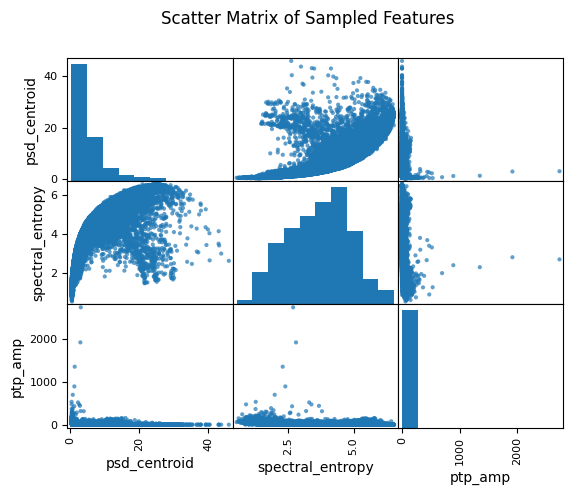

In [ ]:
# Cell 6: Visualize the sampled features without ace_tools

from IPython.display import display

# 1) Show the full DataFrame (or head)
print("Sampled feature set (first 20 rows):")
display(sample_df.head(20))

# 2) Simple summary stats
print("\nSummary statistics:")
display(sample_df.describe())

# 3) Scatter‐matrix plot
from pandas.plotting import scatter_matrix

fig = plt.figure(figsize=(8, 8))
scatter_matrix(
    sample_df[['psd_centroid', 'spectral_entropy', 'ptp_amp']],
    diagonal='hist',
    alpha=0.7
)
plt.suptitle('Scatter Matrix of Sampled Features')
plt.show()


In [ ]:
# Cell 7: Imports for advanced plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from IPython.display import display


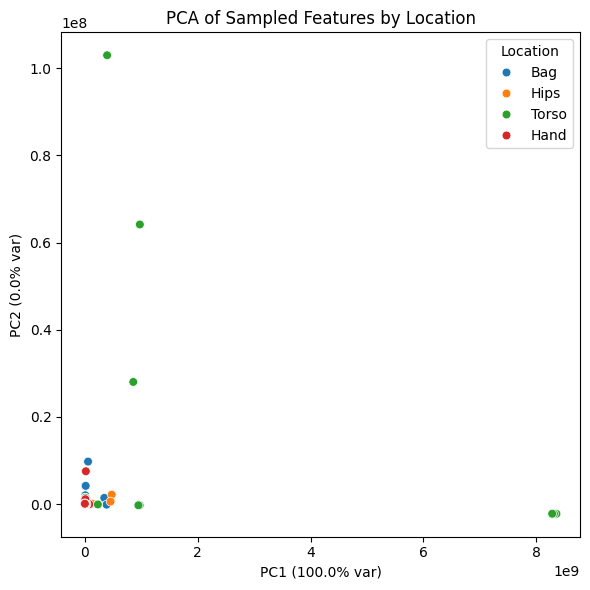

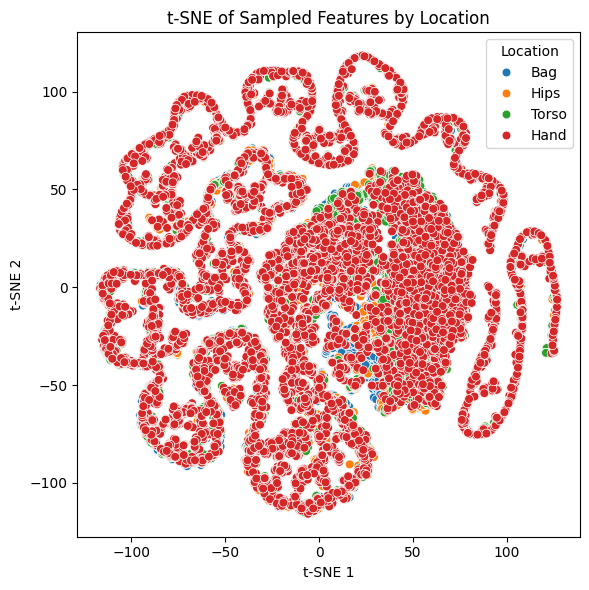

In [ ]:
# Cell 8: PCA + t-SNE colored by location

# Prepare feature matrix (drop metadata)
feat_cols = [c for c in sample_df.columns
             if c not in ('location','sensor_axis','window_id')]
X = sample_df[feat_cols].values

# 1) PCA to 2D
pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],
                hue=sample_df['location'], palette='tab10', s=40)
plt.title('PCA of Sampled Features by Location')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.legend(title='Location')
plt.tight_layout()
plt.show()

# 2) t-SNE to 2D
tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(6,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1],
                hue=sample_df['location'], palette='tab10', s=40)
plt.title('t-SNE of Sampled Features by Location')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Location')
plt.tight_layout()
plt.show()


<ipython-input-27-68dd41d6412f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='location', y=feat, data=sample_df, inner='quartile', palette='Pastel1')


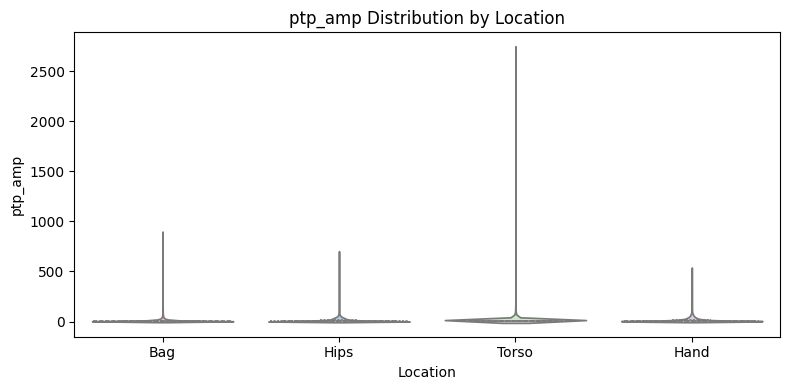

<ipython-input-27-68dd41d6412f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='location', y=feat, data=sample_df, inner='quartile', palette='Pastel1')


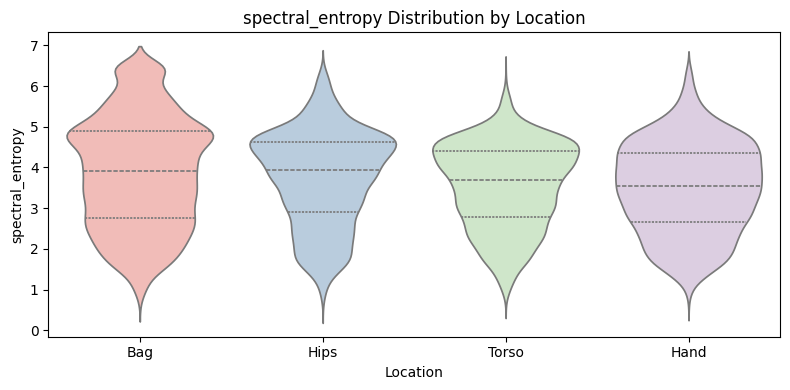

<ipython-input-27-68dd41d6412f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='location', y=feat, data=sample_df, inner='quartile', palette='Pastel1')


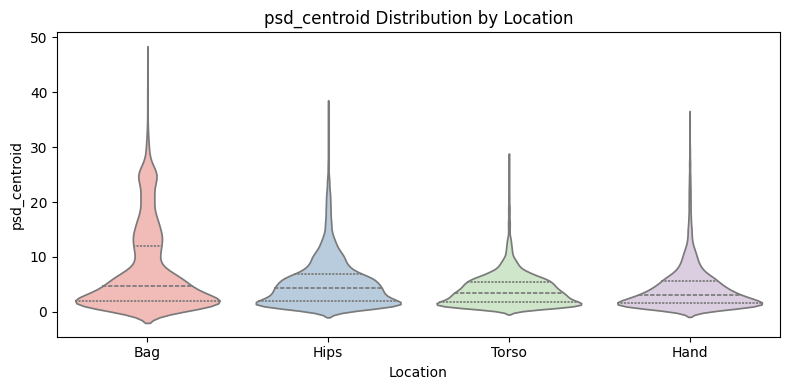

<ipython-input-27-68dd41d6412f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='location', y=feat, data=sample_df, inner='quartile', palette='Pastel1')


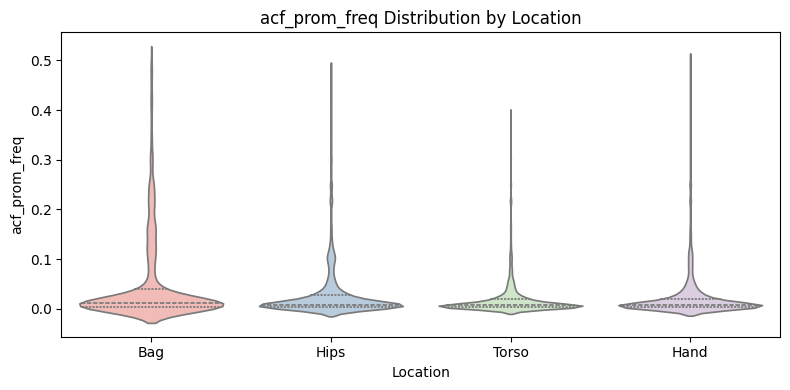

In [ ]:
# Cell 9: Feature distributions per location

# Pick a small set to visualize in detail
viz_feats = ['ptp_amp', 'spectral_entropy',
             'psd_centroid', 'acf_prom_freq']

for feat in viz_feats:
    plt.figure(figsize=(8,4))
    sns.violinplot(x='location', y=feat, data=sample_df, inner='quartile', palette='Pastel1')
    plt.title(f'{feat} Distribution by Location')
    plt.xlabel('Location')
    plt.ylabel(feat)
    plt.tight_layout()
    plt.show()


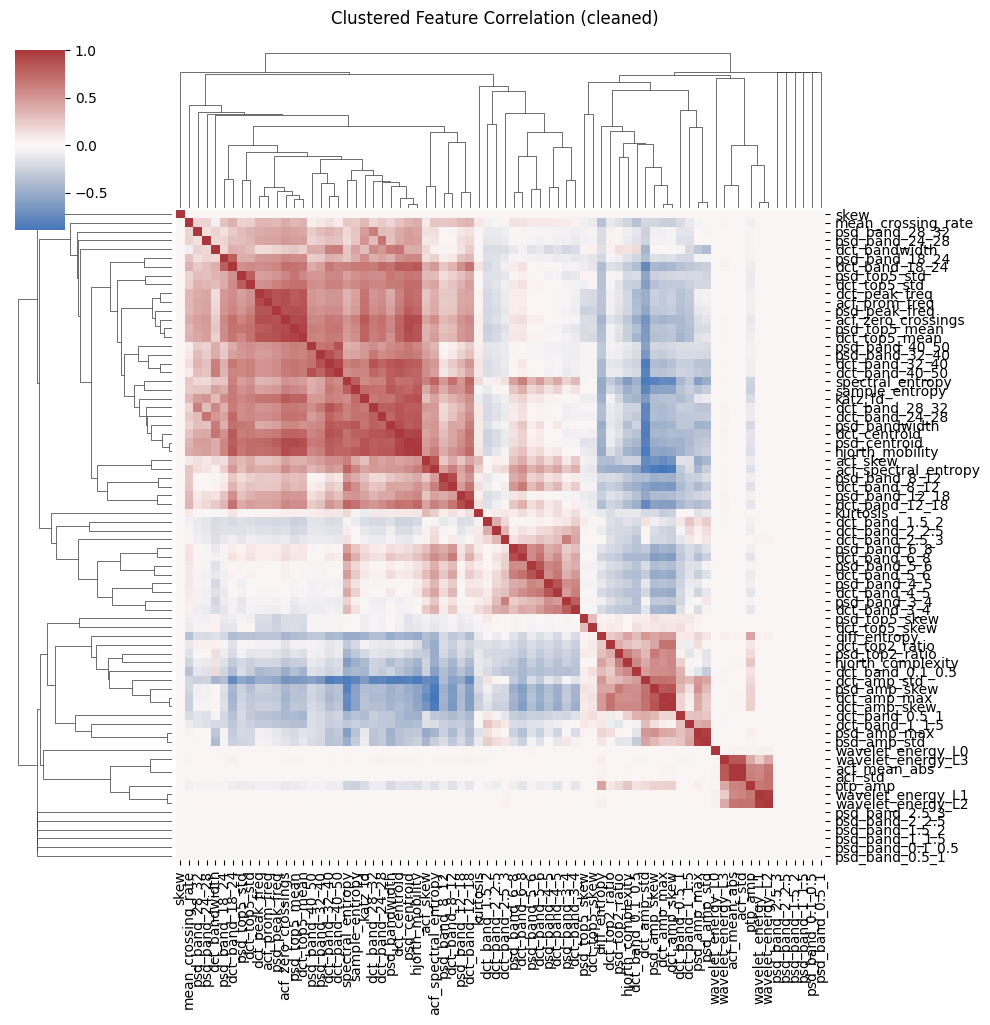

In [ ]:
# Cell 10: Clustered Heatmap of Feature Correlations (cleaned)

import numpy as np
from scipy.cluster.hierarchy import linkage  # <-- correct import :contentReference[oaicite:0]{index=0}
import scipy.spatial.distance as ssd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Compute correlation matrix and clean non-finite values
corr = sample_df[feat_cols].corr()
corr_clean = corr.replace([np.inf, -np.inf], np.nan).fillna(0)

# 2) Build dissimilarity: D = 1 - corr
diss = 1.0 - corr_clean
np.fill_diagonal(diss.values, 0)

# 3) Condense for linkage
diss_condensed = ssd.squareform(diss.values)

# 4) Perform hierarchical clustering with scipy.cluster.hierarchy.linkage :contentReference[oaicite:1]{index=1}
Z = linkage(diss_condensed, method='average')

# 5) Plot clustered heatmap
sns.clustermap(
    corr_clean,
    row_linkage=Z,
    col_linkage=Z,
    cmap='vlag',
    center=0,
    figsize=(10, 10),
    xticklabels=True,
    yticklabels=True
)
plt.suptitle('Clustered Feature Correlation (cleaned)', y=1.02)
plt.show()


In [ ]:
# Cell 11: Summary tables per location

for loc in sample_df['location'].unique():
    sub = sample_df[sample_df['location']==loc]
    print(f'\n=== Summary for {loc} (n={len(sub)}) ===')
    display(sub[feat_cols].describe().T[['mean','std','min','max']])



=== Summary for Bag (n=9000) ===


,mean,std,min,max
psd_band_0.1_0.5,0.000000,0.000000e+00,0.000000,0.000000e+00
psd_band_0.5_1,0.000000,0.000000e+00,0.000000,0.000000e+00
psd_band_1_1.5,0.000000,0.000000e+00,0.000000,0.000000e+00
psd_band_1.5_2,0.000000,0.000000e+00,0.000000,0.000000e+00
psd_band_2_2.5,0.000000,0.000000e+00,0.000000,0.000000e+00
...,...,...,...,...
wavelet_energy_L0,372673.799332,5.664502e+06,0.000011,3.850071e+08
wavelet_energy_L1,206.066885,6.580059e+03,0.000008,6.095039e+05
wavelet_energy_L2,81.852100,9.628645e+02,0.000011,7.479018e+04
wavelet_energy_L3,21.071769,1.663096e+02,0.000007,4.295494e+03



=== Summary for Hips (n=9000) ===


,mean,std,min,max
psd_band_0.1_0.5,0.000000,0.000000e+00,0.000000,0.000000e+00
psd_band_0.5_1,0.000000,0.000000e+00,0.000000,0.000000e+00
psd_band_1_1.5,0.000000,0.000000e+00,0.000000,0.000000e+00
psd_band_1.5_2,0.000000,0.000000e+00,0.000000,0.000000e+00
psd_band_2_2.5,0.000000,0.000000e+00,0.000000,0.000000e+00
...,...,...,...,...
wavelet_energy_L0,378485.343239,7.274993e+06,0.000189,4.761915e+08
wavelet_energy_L1,481.271541,2.335269e+03,0.000054,5.787933e+04
wavelet_energy_L2,248.059168,1.707686e+03,0.000034,5.674916e+04
wavelet_energy_L3,66.188075,6.436443e+02,0.000013,2.623764e+04



=== Summary for Torso (n=9000) ===


,mean,std,min,max
psd_band_0.1_0.5,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
psd_band_0.5_1,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
psd_band_1_1.5,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
psd_band_1.5_2,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
psd_band_2_2.5,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
...,...,...,...,...
wavelet_energy_L0,7.621741e+06,2.339266e+08,0.001008,8.359151e+09
wavelet_energy_L1,2.481153e+03,1.468562e+05,0.000289,1.224476e+07
wavelet_energy_L2,3.175637e+02,1.532154e+04,0.000113,1.346816e+06
wavelet_energy_L3,3.992103e+01,1.984875e+03,0.000024,1.840368e+05



=== Summary for Hand (n=9000) ===


,mean,std,min,max
psd_band_0.1_0.5,0.000000,0.000000e+00,0.000000,0.000000e+00
psd_band_0.5_1,0.000000,0.000000e+00,0.000000,0.000000e+00
psd_band_1_1.5,0.000000,0.000000e+00,0.000000,0.000000e+00
psd_band_1.5_2,0.000000,0.000000e+00,0.000000,0.000000e+00
psd_band_2_2.5,0.000000,0.000000e+00,0.000000,0.000000e+00
...,...,...,...,...
wavelet_energy_L0,189204.687530,1.114746e+06,0.000020,7.860429e+07
wavelet_energy_L1,349.122929,2.440106e+03,0.000017,8.063555e+04
wavelet_energy_L2,224.039985,2.286350e+03,0.000047,1.055981e+05
wavelet_energy_L3,51.920001,6.239487e+02,0.000021,4.051306e+04


# Zapisywanie Plików na Google Drive

In [ ]:
# Cell X: Parallel‐safe feature extraction with lock files

import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# === Settings ===
DATA_ROOT   = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/train_4_locations'
OUTPUT_ROOT = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/features'
LOCATIONS   = ['Bag', 'Hips', 'Torso', 'Hand']
SENSORS     = ['Acc', 'Gyr', 'Mag']
AXES        = ['x','y','z']

# Ensure output dirs
for loc in LOCATIONS:
    os.makedirs(os.path.join(OUTPUT_ROOT, loc), exist_ok=True)

def extract_features_from_file(fp):
    """Extract all windows’ features into a DataFrame."""
    data = np.loadtxt(fp)
    loc    = os.path.basename(os.path.dirname(fp))
    sensor = os.path.splitext(os.path.basename(fp))[0]
    records = []
    for i in tqdm(range(data.shape[0]),
                  desc=f'{sensor} windows',
                  position=1, leave=False):
        win = data[i]
        feats = {}
        feats.update(spectral_features(win))
        feats.update(time_acf_features(win))
        feats.update(time_signal_features(win))
        feats.update(extra_features(win))
        feats['location']    = loc
        feats['sensor_axis'] = sensor
        feats['window_id']   = i
        records.append(feats)
    return pd.DataFrame(records)

signal_files = []
for loc in LOCATIONS:
    for s in SENSORS:
        for ax in AXES:
            pattern = os.path.join(DATA_ROOT, loc, f"{s}_{ax}.txt")
            signal_files.extend(glob.glob(pattern))

for fp in tqdm(signal_files, desc='All signal files', position=0):
    loc    = os.path.basename(os.path.dirname(fp))
    sensor = os.path.splitext(os.path.basename(fp))[0]
    out_csv   = os.path.join(OUTPUT_ROOT, loc, f"{sensor}.csv")
    lock_file = out_csv + '.lock'

    # If features already exist, skip.
    if os.path.exists(out_csv):
        continue

    # If someone else is processing it, skip.
    if os.path.exists(lock_file):
        continue

    # Claim it by creating lock file
    open(lock_file, 'w').close()

    try:
        # Extract & save
        df = extract_features_from_file(fp)
        df.to_csv(out_csv, index=False)
        print(f"✔ Saved features for {sensor} → {out_csv}")
    finally:
        # Remove lock so others know it's done (or if an error occurred)
        if os.path.exists(lock_file):
            os.remove(lock_file)


All signal files:   0%|          | 0/36 [00:00<?, ?it/s]

Acc_y windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Acc_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Acc_y.csv


Gyr_y windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Gyr_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Gyr_y.csv


Mag_z windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Mag_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Mag_z.csv


Gyr_x windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Gyr_x → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hips/Gyr_x.csv


Mag_y windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Mag_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hips/Mag_y.csv


Acc_z windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Acc_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Torso/Acc_z.csv


Gyr_z windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Gyr_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Torso/Gyr_z.csv


Mag_y windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Mag_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Torso/Mag_y.csv


Acc_x windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Acc_x → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hand/Acc_x.csv


Gyr_z windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Gyr_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hand/Gyr_z.csv


Mag_z windows:   0%|          | 0/196072 [00:00<?, ?it/s]

✔ Saved features for Mag_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Hand/Mag_z.csv


# Adding the mode of transport

In [55]:
df=pd.read_csv('/content/drive/MyDrive/Baza danych Challange Sussex 2025/train_4_locations/Bag/Label.txt', header=None, delimiter=' ')
df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
2,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
3,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
4,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196067,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
196068,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
196069,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
196070,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [54]:
df_np = np.array(df)
row_modes = []

for row in df_np:
    values, counts = np.unique(row, return_counts=True)

    most_frequent_value = values[np.argmax(counts)]
    row_modes.append(most_frequent_value)

print(row_modes[1])


4


In [66]:
# Cell X: Parallel‐safe feature extraction with lock files

import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# === Settings ===
DATA_ROOT = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/features'
LOCATIONS   = ['Bag', 'Hips', 'Torso', 'Hand']
SENSORS     = ['Acc', 'Gyr', 'Mag']
AXES        = ['x','y','z']

# Ensure output dirs
for loc in LOCATIONS:
    os.makedirs(os.path.join(DATA_ROOT, loc), exist_ok=True)


signal_files = []
for loc in LOCATIONS:
    for s in SENSORS:
        for ax in AXES:
            pattern = os.path.join(DATA_ROOT, loc, f"{s}_{ax}.csv")
            signal_files.extend(glob.glob(pattern))

for fp in tqdm(signal_files, desc='All signal files', position=0):
    loc    = os.path.basename(os.path.dirname(fp))
    sensor = os.path.splitext(os.path.basename(fp))[0]
    out_csv   = os.path.join(DATA_ROOT, loc, f"{sensor}.csv")
    lock_file = out_csv + '.lock'

    # If someone else is processing it, skip.
    if os.path.exists(lock_file):
        continue

    # Claim it by creating lock file
    open(lock_file, 'w').close()

    try:
        # Extract & save
        df_temp_feature = pd.read_csv(fp)
        for i in range(len(df_temp_feature)):
            df_temp_feature.loc[i, 'mode'] = row_modes[i]
        df_temp_feature.to_csv(out_csv, index=False)
        print(f"✔ Saved features for {sensor} → {out_csv}")
    finally:
        # Remove lock so others know it's done (or if an error occurred)
        if os.path.exists(lock_file):
            os.remove(lock_file)


All signal files:   0%|          | 0/36 [00:00<?, ?it/s]

✔ Saved features for Acc_x → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Acc_x.csv
✔ Saved features for Acc_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Acc_y.csv
✔ Saved features for Acc_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Acc_z.csv
✔ Saved features for Gyr_x → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Gyr_x.csv
✔ Saved features for Gyr_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Gyr_y.csv
✔ Saved features for Gyr_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Gyr_z.csv
✔ Saved features for Mag_x → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Mag_x.csv
✔ Saved features for Mag_y → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Mag_y.csv
✔ Saved features for Mag_z → /content/drive/MyDrive/Baza danych Challange Sussex 2025/features/Bag/Mag_z.csv
✔ Saved features fo

# Simple RandomForest CLassifier

In [16]:
# Cell 1: Imports
import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# === Settings ===
DATA_ROOT = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/features'
glob_pattern = os.path.join(DATA_ROOT, '*', '*.csv')

# === 1. Load + Concatenate All Feature CSVs (with tqdm) ===
all_files = glob.glob(glob_pattern)
print(f"Found {len(all_files)} feature files.")  # Should be 36

dfs = []
for fp in tqdm(all_files, desc='Loading feature CSVs', unit='file'):
    df_tmp = pd.read_csv(fp)
    dfs.append(df_tmp)

df_all = pd.concat(dfs, axis=0, ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print("Combined shape (before sampling):", df_all.shape)
print("Mode distribution:\n", df_all['mode'].value_counts())

# === 2. Take a 10% Random Sample (for speed) ===
df_sample = df_all.sample(frac=0.010, random_state=42).reset_index(drop=True)
print("Sampled shape (10%):", df_sample.shape)
print("Mode distribution in sample:\n", df_sample['mode'].value_counts())

# === 3. One-Hot Encode 'location' and 'sensor_axis' ===
df_encoded = pd.get_dummies(
    df_sample.drop(columns=['mode']),
    columns=['location', 'sensor_axis'],
    prefix=['loc', 'axis'],
    drop_first=False,
    dtype=np.uint8
)
print("Shape after one-hot encoding:", df_encoded.shape)

# === 4. Split into Features (X) and Target (y) ===
X = df_encoded
y = df_sample['mode']

# === 5. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print("Training size:", X_train.shape, "| Testing size:", X_test.shape)

# === 6a. Train a Larger Random Forest ===
rf_large = RandomForestClassifier(
    n_estimators=10,       # More trees
    max_depth=20,           # Limit depth to prevent overfitting
    random_state=42,
    n_jobs=-1,
    verbose=1               # Show per-tree progress
)
print("\nTraining Random Forest with n_estimators=200, max_depth=20 …")
rf_large.fit(X_train, y_train)


# === 7a. Evaluate Random Forest ===
y_pred_rf = rf_large.predict(X_test)
print("\n=== Random Forest: Classification Report ===")
print(classification_report(y_test, y_pred_rf, digits=4))
print("=== Random Forest: Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_rf))


# === 6b. Train a Gradient Boosting Classifier ===
gbt = GradientBoostingClassifier(
    n_estimators=10,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose=1
)
print("\nTraining Gradient Boosting (n_estimators=100, learning_rate=0.1, max_depth=5) …")
gbt.fit(X_train, y_train)



# === 7b. Evaluate Gradient Boosting ===
y_pred_gbt = gbt.predict(X_test)
print("\n=== Gradient Boosting: Classification Report ===")
print(classification_report(y_test, y_pred_gbt, digits=4))
print("=== Gradient Boosting: Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_gbt))


Found 36 feature files.


Loading feature CSVs:   0%|          | 0/36 [00:00<?, ?file/s]

Combined shape (before sampling): (7058592, 78)
Mode distribution:
 mode
5.0    1142388
7.0    1125108
6.0    1019736
2.0     883584
1.0     880416
8.0     858024
4.0     845028
3.0     304308
Name: count, dtype: int64
Sampled shape (10%): (70586, 78)
Mode distribution in sample:
 mode
7.0    11347
5.0    11215
6.0    10281
2.0     8853
1.0     8735
8.0     8603
4.0     8526
3.0     3026
Name: count, dtype: int64
Shape after one-hot encoding: (70586, 88)
Training size: (56468, 88) | Testing size: (14118, 88)

Training Random Forest with n_estimators=200, max_depth=20 …


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished



=== Random Forest: Classification Report ===
              precision    recall  f1-score   support

         1.0     0.5170    0.5318    0.5243      1747
         2.0     0.6922    0.7239    0.7077      1771
         3.0     0.8852    0.7901    0.8349       605
         4.0     0.6659    0.6393    0.6523      1705
         5.0     0.6193    0.6549    0.6366      2243
         6.0     0.5013    0.4859    0.4935      2056
         7.0     0.4124    0.4586    0.4343      2270
         8.0     0.3336    0.2719    0.2996      1721

    accuracy                         0.5494     14118
   macro avg     0.5784    0.5695    0.5729     14118
weighted avg     0.5475    0.5494    0.5476     14118

=== Random Forest: Confusion Matrix ===
[[ 929   23    0   22  121  180  279  193]
 [  23 1282   17  190   45   46   93   75]
 [   0   46  478   61    6    3    9    2]
 [  25  254   23 1090   76   75  100   62]
 [ 132   70   11   56 1469  291  135   79]
 [ 190   45    2   49  371  999  270  130]
 [ 26


Training Random Forest with n_estimators=200, max_depth=20 …


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished



=== Random Forest: Classification Report ===
              precision    recall  f1-score   support

         1.0     0.5758    0.6045    0.5898      1747
         2.0     0.7697    0.7815    0.7756      1771
         3.0     0.9461    0.8413    0.8906       605
         4.0     0.7351    0.7015    0.7179      1705
         5.0     0.6762    0.7205    0.6976      2243
         6.0     0.5676    0.5516    0.5594      2056
         7.0     0.4564    0.5423    0.4957      2270
         8.0     0.4159    0.2987    0.3476      1721

    accuracy                         0.6120     14118
   macro avg     0.6428    0.6302    0.6343     14118
weighted avg     0.6113    0.6120    0.6095     14118

=== Random Forest: Confusion Matrix ===
[[1056   19    0   17   90  181  245  139]
 [  19 1384    6  141   35   42   78   66]
 [   0   35  509   43    8    0    9    1]
 [  23  194   14 1196   64   53   95   66]
 [ 113   36    6   54 1616  232  136   50]
 [ 172   33    2   40  323 1134  258   94]
 [ 24

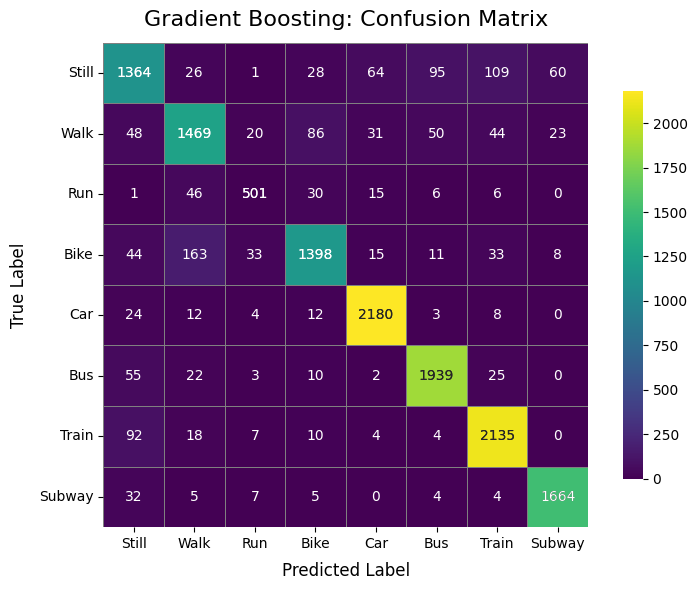

In [32]:
import seaborn as sns
labels = ["Still","Walk","Run","Bike","Car","Bus","Train","Subway"]
cmap_choice = plt.cm.viridis


# === 6a. Train a Larger Random Forest ===
rf_large = RandomForestClassifier(
    n_estimators=100,       # More trees
    max_depth=50,           # Limit depth to prevent overfitting
    random_state=42,
    n_jobs=-1,
    verbose=1               # Show per-tree progress
)
print("\nTraining Random Forest with n_estimators=200, max_depth=20 …")
rf_large.fit(X_train, y_train)


# === 7a. Evaluate Random Forest ===
y_pred_rf = rf_large.predict(X_test)
print("\n=== Random Forest: Classification Report ===")
print(classification_report(y_test, y_pred_rf, digits=4))
print("=== Random Forest: Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred_rf))


# === 6b. Train a Gradient Boosting Classifier ===
gbt = GradientBoostingClassifier(
    n_estimators=12,
    learning_rate=0.3,
    max_depth=7,
    random_state=42,
    verbose=1
)
print("\nTraining Gradient Boosting (n_estimators=12, learning_rate=0.3, max_depth=7) …")
gbt.fit(X_train, y_train)



# === 7b. Evaluate Gradient Boosting ===
y_pred_gbt = gbt.predict(X_test)
print("\n=== Gradient Boosting: Classification Report ===")
print(classification_report(y_test, y_pred_gbt, digits=4))

# Plot the GBT confusion matrix similarly
cm_gbt = confusion_matrix(y_test, y_pred_gbt)  # 8×8 array
cm_gbt_df = pd.DataFrame(cm_gbt, index=labels, columns=labels)

fig2, ax2 = plt.subplots(figsize=(8, 6), dpi=100)
sns.heatmap(
    cm_gbt_df,
    annot=True,
    fmt="d",
    cmap=cmap_choice,
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax2
)

mask2 = np.zeros_like(cm_gbt_df, dtype=bool)
for i in range(len(cm_gbt_df)):
    for j in range(len(cm_gbt_df)):
        if i != j:
            mask2[i, j] = True

sns.heatmap(
    cm_gbt_df,
    mask=mask2,
    cmap=cmap_choice,
    annot=True,
    fmt="d",
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar=False,
    ax=ax2
)

ax2.set_title("Gradient Boosting: Confusion Matrix", fontsize=16, pad=12)
ax2.set_xlabel("Predicted Label", fontsize=12, labelpad=8)
ax2.set_ylabel("True Label", fontsize=12, labelpad=8)

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=10)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# Above had the issue of window_id not being excluded, and it learned that specific window_id ranges differ in transport, just because they are sequentially given from beginning to end of recording

# More Data **1% -> 5%**

In [2]:
pip install --q xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.4 MB/s eta 0:00:00


Found 36 feature files.


Loading feature CSVs:   0%|          | 0/36 [00:00<?, ?file/s]

Combined shape (before sampling): (7058592, 78)
Mode distribution:
 mode
5.0    1142388
7.0    1125108
6.0    1019736
2.0     883584
1.0     880416
8.0     858024
4.0     845028
3.0     304308
Name: count, dtype: int64
Sampled shape (5%): (352930, 78)
Mode distribution in sample:
 mode
5.0    56841
7.0    56242
6.0    51077
2.0    44378
1.0    43944
8.0    42867
4.0    42407
3.0    15174
Name: count, dtype: int64
Shape after one-hot encoding (and dropping window_id): (352930, 78)
Training size: (282344, 78) | Testing size: (70586, 78)

Training XGBoost (n_estimators=80, max_depth=8, learning_rate=0.1) …


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:06:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost: Classification Report ===
              precision    recall  f1-score   support

           0     0.5535    0.6467    0.5965      8789
           1     0.8279    0.8220    0.8249      8876
           2     0.9510    0.9265    0.9386      3035
           3     0.7720    0.7704    0.7712      8481
           4     0.6836    0.7293    0.7057     11368
           5     0.5975    0.5709    0.5839     10215
           6     0.4930    0.5057    0.4993     11249
           7     0.4276    0.3319    0.3737      8573

    accuracy                         0.6373     70586
   macro avg     0.6632    0.6629    0.6617     70586
weighted avg     0.6337    0.6373    0.6341     70586



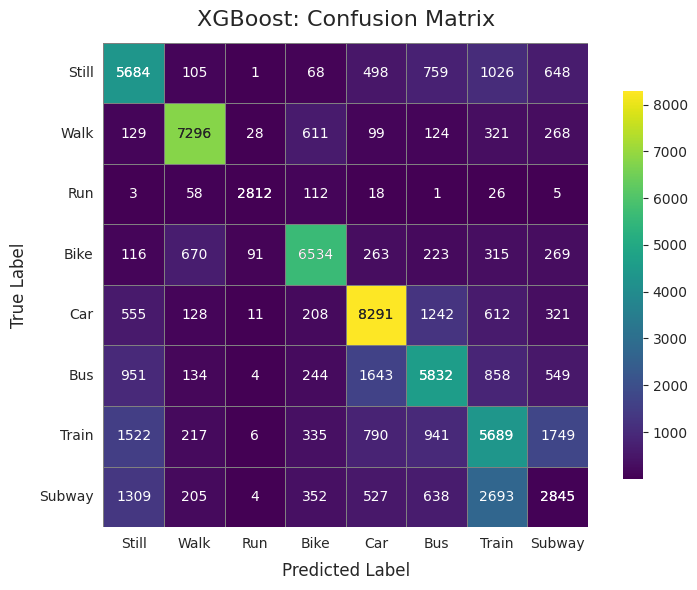


Top 10 Features – XGBoost (by gain):
              feature  importance
0        diff_entropy    0.063238
1             acf_std    0.060023
2       psd_peak_freq    0.057823
3       dct_peak_freq    0.048737
4             ptp_amp    0.038132
5   wavelet_energy_L1    0.036341
6        acf_mean_abs    0.034272
7  mean_crossing_rate    0.034255
8      sample_entropy    0.030987
9         dct_amp_std    0.030615


<ipython-input-17-8ca34407ba05>:283: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


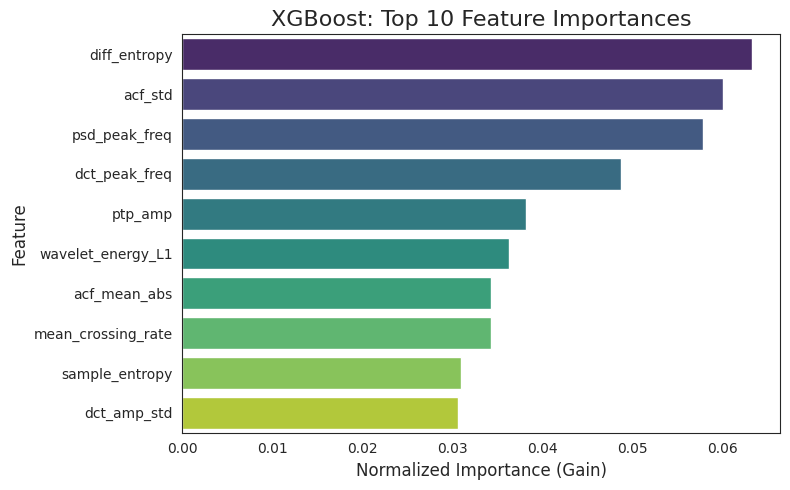

In [17]:
# Cell 1: Imports
import os
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# Machine Learning Imports
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import xgboost as xgb

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns

# === Settings ===
DATA_ROOT = '/content/drive/MyDrive/Baza danych Challange Sussex 2025/features'
glob_pattern = os.path.join(DATA_ROOT, '*', '*.csv')

# === 1. Load + Concatenate All Feature CSVs (with tqdm) ===
all_files = glob.glob(glob_pattern)
print(f"Found {len(all_files)} feature files.")  # Expect 36

dfs = []
for fp in tqdm(all_files, desc='Loading feature CSVs', unit='file'):
    df_tmp = pd.read_csv(fp)   # Each CSV: numeric features + 'location' + 'sensor_axis' + 'mode'
    dfs.append(df_tmp)

df_all = pd.concat(dfs, axis=0, ignore_index=True)
df_all = df_all.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle

print("Combined shape (before sampling):", df_all.shape)
print("Mode distribution:\n", df_all['mode'].value_counts())

# === 2. Take a 5% Random Sample (for speed) ===
df_sample = df_all.sample(frac=0.05, random_state=42).reset_index(drop=True)
print("Sampled shape (5%):", df_sample.shape)
print("Mode distribution in sample:\n", df_sample['mode'].value_counts())

# === 3. One-Hot Encode 'location' and 'sensor_axis' ===
df_encoded = pd.get_dummies(
    df_sample.drop(columns=['mode', 'sensor_axis']),
    columns=['location'],
    prefix=['loc'],
    drop_first=False,
    dtype=np.uint8
).drop(columns=['window_id'])  # ← drop window_id here

print("Shape after one-hot encoding (and dropping window_id):", df_encoded.shape)

# === 4. Split into Features (X) and Target (y) ===
X = df_encoded
y = df_sample['mode']

# === 5. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)
print("Training size:", X_train.shape, "| Testing size:", X_test.shape)

# Pre-define plotting parameters and labels
labels = ["Still","Walk","Run","Bike","Car","Bus","Train","Subway"]
sns.set_style("white")
cmap_choice = plt.cm.viridis


'''
# === 6a. Train a Random Forest ===
rf_large = RandomForestClassifier(
    n_estimators=100,      # More trees for better generalization
    max_depth=50,          # Limit depth to reduce overfitting
    random_state=42,
    n_jobs=-1,
    verbose=1              # Show per-tree progress
)
print("\nTraining Random Forest (n_estimators=100, max_depth=50) …")
rf_large.fit(X_train, y_train)  # Already-fitted model stores feature_importances_

# === 7a. Evaluate Random Forest ===
y_pred_rf = rf_large.predict(X_test)
print("\n=== Random Forest: Classification Report ===")
print(classification_report(y_test, y_pred_rf, digits=4))

# Plot RF confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_df = pd.DataFrame(cm_rf, index=labels, columns=labels)

fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
sns.heatmap(
    cm_rf_df,
    annot=True,
    fmt="d",
    cmap=cmap_choice,
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax
)

mask = np.zeros_like(cm_rf_df, dtype=bool)
for i in range(len(cm_rf_df)):
    for j in range(len(cm_rf_df)):
        if i != j:
            mask[i, j] = True

sns.heatmap(
    cm_rf_df,
    mask=mask,
    cmap=cmap_choice,
    annot=True,
    fmt="d",
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar=False,
    ax=ax
)

ax.set_title("Random Forest: Confusion Matrix", fontsize=16, pad=12)
ax.set_xlabel("Predicted Label", fontsize=12, labelpad=8)
ax.set_ylabel("True Label", fontsize=12, labelpad=8)

ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

# === 6b. Train a Gradient Boosting Classifier ===
gbt = GradientBoostingClassifier(
    n_estimators=12,
    learning_rate=0.3,
    max_depth=7,
    random_state=42,
    verbose=1
)
print("\nTraining Gradient Boosting (n_estimators=12, learning_rate=0.3, max_depth=7) …")
gbt.fit(X_train, y_train)

# === 7b. Evaluate Gradient Boosting ===
y_pred_gbt = gbt.predict(X_test)
print("\n=== Gradient Boosting: Classification Report ===")
print(classification_report(y_test, y_pred_gbt, digits=4))

# Plot GBT confusion matrix
cm_gbt = confusion_matrix(y_test, y_pred_gbt)
cm_gbt_df = pd.DataFrame(cm_gbt, index=labels, columns=labels)

fig2, ax2 = plt.subplots(figsize=(8, 6), dpi=100)
sns.heatmap(
    cm_gbt_df,
    annot=True,
    fmt="d",
    cmap=cmap_choice,
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax2
)

mask2 = np.zeros_like(cm_gbt_df, dtype=bool)
for i in range(len(cm_gbt_df)):
    for j in range(len(cm_gbt_df)):
        if i != j:
            mask2[i, j] = True

sns.heatmap(
    cm_gbt_df,
    mask=mask2,
    cmap=cmap_choice,
    annot=True,
    fmt="d",
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar=False,
    ax=ax2
)

ax2.set_title("Gradient Boosting: Confusion Matrix", fontsize=16, pad=12)
ax2.set_xlabel("Predicted Label", fontsize=12, labelpad=8)
ax2.set_ylabel("True Label", fontsize=12, labelpad=8)

ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=10)
ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=10)

plt.tight_layout()
plt.show()
'''





# === 9. XGBoost ===
# Encode y labels from 1–8 to 0–7 for XGBoost compatibility
y_train_enc = y_train.astype(int) - 1
y_test_enc  = y_test.astype(int)  - 1

xgb_model = xgb.XGBClassifier(
    booster='gbtree',
    n_estimators=80,
    max_depth=8,
    learning_rate=0.3,
    random_state=42,
    n_jobs=-1,
    verbose =1
)
print("\nTraining XGBoost (n_estimators=80, max_depth=8, learning_rate=0.1) …")
xgb_model.fit(X_train, y_train_enc)

# XGB Evaluation (on encoded labels)
y_pred_xgb_enc = xgb_model.predict(X_test)
print("\n=== XGBoost: Classification Report ===")
print(classification_report(y_test_enc, y_pred_xgb_enc, digits=4))

# Build confusion matrix and map back to original class names
cm_xgb = confusion_matrix(y_test_enc, y_pred_xgb_enc)
cm_xgb_df = pd.DataFrame(cm_xgb, index=labels, columns=labels)

fig3, ax3 = plt.subplots(figsize=(8, 6), dpi=100)
sns.heatmap(
    cm_xgb_df,
    annot=True,
    fmt="d",
    cmap=cmap_choice,
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"shrink": 0.8},
    ax=ax3
)
mask3 = np.zeros_like(cm_xgb_df, dtype=bool)
for i in range(len(cm_xgb_df)):
    for j in range(len(cm_xgb_df)):
        if i != j:
            mask3[i, j] = True

sns.heatmap(
    cm_xgb_df,
    mask=mask3,
    cmap=cmap_choice,
    annot=True,
    fmt="d",
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar=False,
    ax=ax3
)
ax3.set_title("XGBoost: Confusion Matrix", fontsize=16, pad=12)
ax3.set_xlabel("Predicted Label", fontsize=12, labelpad=8)
ax3.set_ylabel("True Label", fontsize=12, labelpad=8)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0, fontsize=10)
ax3.set_yticklabels(ax3.get_yticklabels(), rotation=0, fontsize=10)
plt.tight_layout()
plt.show()




# === 10. XGBoost Feature Importances (no retraining) ===
xgb_importances = xgb_model.feature_importances_
feature_names = X_train.columns.tolist()

importance_df_xgb = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

print("\nTop 10 Features – XGBoost (by gain):")
print(importance_df_xgb.head(10))

plt.figure(figsize=(8, 5), dpi=100)
sns.barplot(
    data=importance_df_xgb.head(10),
    x='importance',
    y='feature',
    palette='viridis'
)
plt.title("XGBoost: Top 10 Feature Importances", fontsize=16)
plt.xlabel("Normalized Importance (Gain)", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# Using up to 42GB of RAM to fit all the data inside memory